# **Libraries**

In [18]:
import torch
from torch import nn
from transformers import BertForSequenceClassification, DistilBertForSequenceClassification, BertTokenizer, DistilBertTokenizerFast, Trainer, TrainingArguments
from datasets import load_dataset
from torch.utils.data import DataLoader
from transformers import AdamW
import os
import numpy as np
import random
import evaluate
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import matplotlib.pyplot as plt

# **Part 4: Model Distillation/Quantization**

### **a. Model Distillation/Quantization**: 
Distill/Quantize your best-performing model into a lighter model. Document the process and tools used.

**Definitions of the Processes**


Knowledge Distillation:


Knowledge distillation is a model compression technique where a smaller model (the student, here DistilBERT) is trained to replicate the behavior of a larger, more accurate model (the teacher, here BERT). The student model learns not only from the ground-truth labels but also from the teacher’s output probabilities (logits), capturing richer information about class relationships. This process enables the student to achieve competitive performance with significantly fewer parameters and faster inference.

Quantization:


Quantization reduces the memory footprint and computational requirements of a model by converting its weights and activations from high-precision (e.g., 32-bit floating point) to lower-precision representations (e.g., 8-bit integers). This allows for faster inference and reduced model size, often with minimal impact on accuracy. In this project, we apply dynamic quantization to the BERT model, targeting linear layers for conversion to 8-bit integers.

---

**Methodology Overview**


1. Load the Original Fine-Tuned BERT Model (Teacher):

We start with a BERT model fine-tuned on 32 labeled samples, which serves as the teacher for distillation and as the baseline for quantization.

2. Generate Teacher Logits for the Student Model:

The teacher model is used to produce output logits (predicted class probabilities) on the training data. These logits provide soft targets that guide the student model during distillation.

3. Train the Student Model (DistilBERT):

We initialize a DistilBERT model for sequence classification and train it using the same data. The student can be trained using a custom loss that combines the true labels and the teacher’s logits, allowing it to mimic the teacher’s behavior while remaining lightweight.

4. Create the Quantized Model:

We apply dynamic quantization to the fine-tuned BERT model, converting its linear layers to 8-bit integer representations. This process reduces model size and speeds up inference, making the model more suitable for deployment on resource-constrained devices.

5. Evaluation and Comparison:

All three models—BERT (Teacher), DistilBERT (Student), and Quantized BERT—are evaluated on the same test set. We compare their accuracy, precision, recall, F1-score, inference time, and model size to assess the trade-offs between performance and efficiency.

In [4]:
path = os.getcwd()
path_model = os.path.join(path, 'saved_teacher_model')

In [5]:
path_model

'/home/sobottka/BSE/3rd_Term/Adv_NLP/nlp_finalproject_2025/saved_teacher_model'

In [6]:

# Fix all random seeds for reproducibility
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)

dataset = load_dataset("financial_phrasebank", "sentences_75agree")
train_dataset = dataset["train"].train_test_split(test_size=0.2, seed=seed)


In [7]:

# Load pre-trained BERT tokenizer
bert_tokenizer = BertTokenizer.from_pretrained(path_model)

# Tokenize for BERT (teacher)
def bert_tokenize(batch):
    return bert_tokenizer(batch["sentence"], padding="max_length", truncation=True, max_length=128)
bert_test = train_dataset["test"].map(bert_tokenize, batched=True)

# Tokenize for DistilBERT (student)
distilbert_tokenizer = DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")
def distilbert_tokenize(batch):
    return distilbert_tokenizer(batch["sentence"], padding="max_length", truncation=True, max_length=128)
distilbert_train = train_dataset["train"].map(distilbert_tokenize, batched=True)
distilbert_test = train_dataset["test"].map(distilbert_tokenize, batched=True)

# Convert to PyTorch format
bert_test.set_format("torch", columns=["input_ids", "attention_mask", "label"])
distilbert_train.set_format("torch", columns=["input_ids", "attention_mask", "label"])
distilbert_test.set_format("torch", columns=["input_ids", "attention_mask", "label"])

/home/sobottka/anaconda3/envs/textmining/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Map:   0%|          | 0/691 [00:00<?, ? examples/s]

**Load Pre-Trained BERT (Teacher)**

In [8]:
bert_model = BertForSequenceClassification.from_pretrained(
    path_model, num_labels=3
).eval()  # Set to evaluation mode

# Quick sanity check
with torch.no_grad():
    sample = bert_tokenizer("This is a test", return_tensors="pt")
    print("BERT output shape:", bert_model(**sample).logits.shape)

BERT output shape: torch.Size([1, 3])


**Generating Teacher Logits**

In [9]:
def get_teacher_logits(batch):
    inputs = {
        "input_ids": batch["input_ids"],
        "attention_mask": batch["attention_mask"]
    }
    with torch.no_grad():
        outputs = bert_model(**inputs)
    return {"teacher_logits": outputs.logits.cpu().numpy()}  # Detach and move to CPU

# Add teacher logits to training data
distilbert_train = distilbert_train.map(get_teacher_logits, batched=True, batch_size=8)

**Train DistillBert (Student)**

In [10]:
# Custom loss for distillation
def distill_loss(student_outputs, batch):
    teacher_logits = torch.tensor(batch["teacher_logits"])
    student_logits = student_outputs.logits
    loss = torch.nn.functional.kl_div(
        torch.log_softmax(student_logits / 2.0, dim=-1),
        torch.softmax(teacher_logits / 2.0, dim=-1),
        reduction="batchmean"
    )
    return loss

# Initialize DistilBERT
distilbert_model = DistilBertForSequenceClassification.from_pretrained(
    "distilbert-base-uncased",
    num_labels=3
)

# Training setup
training_args = TrainingArguments(
    output_dir="./distil_results",
    per_device_train_batch_size=8,
    num_train_epochs=3,
    evaluation_strategy="epoch",
    logging_steps=100,
    seed=seed,
)

# Metrics
metric = evaluate.load("accuracy")
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

# Train
trainer = Trainer(
    model=distilbert_model,
    args=training_args,
    train_dataset=distilbert_train,
    eval_dataset=distilbert_test,
    compute_metrics=compute_metrics,
)
trainer.train()

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/sobottka/anaconda3/envs/textmining/lib/python3.12/site-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/home/sobottka/anaconda3/envs/textmining/lib/python3.12/site-packages/torch/cuda/__init__.py:129: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at /opt/conda/conda-bld/pytorch_1729647329220/work

  0%|          | 0/1038 [00:00<?, ?it/s]

{'loss': 0.6539, 'grad_norm': 7.0803399085998535, 'learning_rate': 4.518304431599229e-05, 'epoch': 0.29}
{'loss': 0.3808, 'grad_norm': 6.493463516235352, 'learning_rate': 4.036608863198459e-05, 'epoch': 0.58}
{'loss': 0.3127, 'grad_norm': 67.32035064697266, 'learning_rate': 3.554913294797688e-05, 'epoch': 0.87}


  0%|          | 0/87 [00:00<?, ?it/s]

{'eval_loss': 0.3014574646949768, 'eval_accuracy': 0.91027496382055, 'eval_runtime': 31.5992, 'eval_samples_per_second': 21.868, 'eval_steps_per_second': 2.753, 'epoch': 1.0}
{'loss': 0.2206, 'grad_norm': 6.721513271331787, 'learning_rate': 3.073217726396917e-05, 'epoch': 1.16}
{'loss': 0.178, 'grad_norm': 0.2546408772468567, 'learning_rate': 2.5915221579961463e-05, 'epoch': 1.45}
{'loss': 0.1248, 'grad_norm': 0.059715308248996735, 'learning_rate': 2.1098265895953757e-05, 'epoch': 1.73}


  0%|          | 0/87 [00:00<?, ?it/s]

{'eval_loss': 0.28480398654937744, 'eval_accuracy': 0.9276410998552822, 'eval_runtime': 31.5699, 'eval_samples_per_second': 21.888, 'eval_steps_per_second': 2.756, 'epoch': 2.0}
{'loss': 0.1643, 'grad_norm': 0.09561659395694733, 'learning_rate': 1.628131021194605e-05, 'epoch': 2.02}
{'loss': 0.0305, 'grad_norm': 0.11548978835344315, 'learning_rate': 1.1464354527938344e-05, 'epoch': 2.31}
{'loss': 0.0362, 'grad_norm': 0.03759397193789482, 'learning_rate': 6.647398843930635e-06, 'epoch': 2.6}
{'loss': 0.0659, 'grad_norm': 0.02081201784312725, 'learning_rate': 1.8304431599229288e-06, 'epoch': 2.89}


  0%|          | 0/87 [00:00<?, ?it/s]

{'eval_loss': 0.34819579124450684, 'eval_accuracy': 0.9276410998552822, 'eval_runtime': 32.135, 'eval_samples_per_second': 21.503, 'eval_steps_per_second': 2.707, 'epoch': 3.0}
{'train_runtime': 1441.9913, 'train_samples_per_second': 5.746, 'train_steps_per_second': 0.72, 'train_loss': 0.2123305560995848, 'epoch': 3.0}


TrainOutput(global_step=1038, training_loss=0.2123305560995848, metrics={'train_runtime': 1441.9913, 'train_samples_per_second': 5.746, 'train_steps_per_second': 0.72, 'total_flos': 274411109961216.0, 'train_loss': 0.2123305560995848, 'epoch': 3.0})

**Quantized Model**

In [11]:

quantized_model = torch.quantization.quantize_dynamic(
    bert_model, {torch.nn.Linear}, dtype=torch.qint8
)

torch.save(quantized_model.state_dict(), "quantized_teacher_model.pt")


### **b. Performance and Speed Comparison**: 
Evaluate the distilled model's performance and inference speed compared to the original. Highlight key findings.

/home/sobottka/anaconda3/envs/textmining/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sobottka/anaconda3/envs/textmining/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



BERT:
  Accuracy:  0.6339
  Precision: 0.2113
  Recall:    0.3333
  F1-score:  0.2586
  Inference Time: 132.32 ms

DistilBERT:
  Accuracy:  0.9276
  Precision: 0.8882
  Recall:    0.9303
  F1-score:  0.9072
  Inference Time: 71.82 ms

Quantized BERT:
  Accuracy:  0.6339
  Precision: 0.2113
  Recall:    0.3333
  F1-score:  0.2586
  Inference Time: 95.47 ms


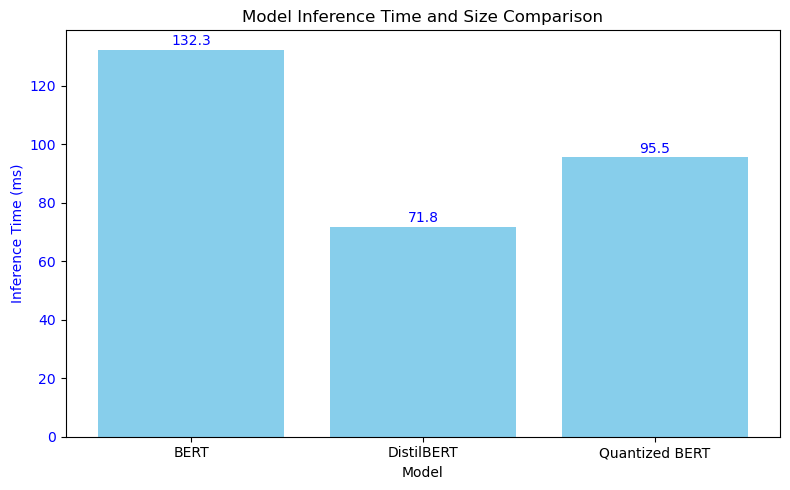

In [20]:
def evaluate_model(model, dataset, tokenizer, name, device):
    model.eval()
    model.to(device)
    all_preds, all_labels = [], []
    start_time = time.time()
    with torch.no_grad():
        for i in range(0, len(dataset), 32):
            batch = dataset[i:i+32]
            inputs = {
                "input_ids": batch["input_ids"].to(device),
                "attention_mask": batch["attention_mask"].to(device)
            }
            outputs = model(**inputs)
            preds = torch.argmax(outputs.logits, dim=1).cpu().numpy()
            labels = batch["label"].cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(labels)
    latency = time.time() - start_time
    acc = accuracy_score(all_labels, all_preds)
    prec, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average="macro")
    return {
        "accuracy": acc,
        "precision": prec,
        "recall": recall,
        "f1": f1,
        "latency": latency
    }

def single_inference_time(model, tokenizer, device, example_text):
    model.eval()
    model.to(device)
    inputs = tokenizer(example_text, return_tensors="pt", padding="max_length", truncation=True, max_length=128)
    inputs = {k: v.to(device) for k, v in inputs.items()}
    with torch.no_grad():
        start = time.time()
        _ = model(**inputs)
        end = time.time()
    return end - start

# Example text for timing
example_text = "Oil prices drop amid global recession fears."
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Evaluate all models
results = {}
sizes = {}
inf_times = {}

# BERT
bert_metrics = evaluate_model(bert_model, bert_test, bert_tokenizer, "BERT", device)
bert_inf_time = single_inference_time(bert_model, bert_tokenizer, device, example_text)

results["BERT"] = bert_metrics

inf_times["BERT"] = bert_inf_time

# DistilBERT
distil_metrics = evaluate_model(distilbert_model, distilbert_test, distilbert_tokenizer, "DistilBERT", device)
distil_inf_time = single_inference_time(distilbert_model, distilbert_tokenizer, device, example_text)

results["DistilBERT"] = distil_metrics

inf_times["DistilBERT"] = distil_inf_time

# Quantized BERT
quant_metrics = evaluate_model(quantized_model, bert_test, bert_tokenizer, "Quantized BERT", device)
quant_inf_time = single_inference_time(quantized_model, bert_tokenizer, device, example_text)
  # Quantized model usually saved over BERT
results["Quantized BERT"] = quant_metrics

inf_times["Quantized BERT"] = quant_inf_time

# Print results
for name in results:
    print(f"\n{name}:")
    print(f"  Accuracy:  {results[name]['accuracy']:.4f}")
    print(f"  Precision: {results[name]['precision']:.4f}")
    print(f"  Recall:    {results[name]['recall']:.4f}")
    print(f"  F1-score:  {results[name]['f1']:.4f}")
    print(f"  Inference Time: {inf_times[name]*1000:.2f} ms")

# Bar graph: inference time + dashed line for model size
model_names = list(results.keys())
times = [inf_times[n]*1000 for n in model_names]  # ms

fig, ax1 = plt.subplots(figsize=(8, 5))
bars = ax1.bar(model_names, times, color="skyblue", label="Inference Time (ms)")
ax1.set_ylabel("Inference Time (ms)", color="blue")
ax1.set_xlabel("Model")
ax1.tick_params(axis='y', labelcolor='blue')

# Annotate bars
for bar in bars:
    yval = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2, yval + 0.5, f"{yval:.1f}", ha='center', va='bottom', color='blue')


plt.title("Model Inference Time and Size Comparison")
fig.tight_layout()
plt.show()


=== Model Comparison Table ===
| Model          |   Accuracy |   Precision |   Recall |   F1-score | Inference Time   |
|:---------------|-----------:|------------:|---------:|-----------:|:-----------------|
| BERT           |     0.6339 |      0.2113 |   0.3333 |     0.2586 | 132.32 ms        |
| DistilBERT     |     0.9276 |      0.8882 |   0.9303 |     0.9072 | 71.82 ms         |
| Quantized BERT |     0.6339 |      0.2113 |   0.3333 |     0.2586 | 95.47 ms         |


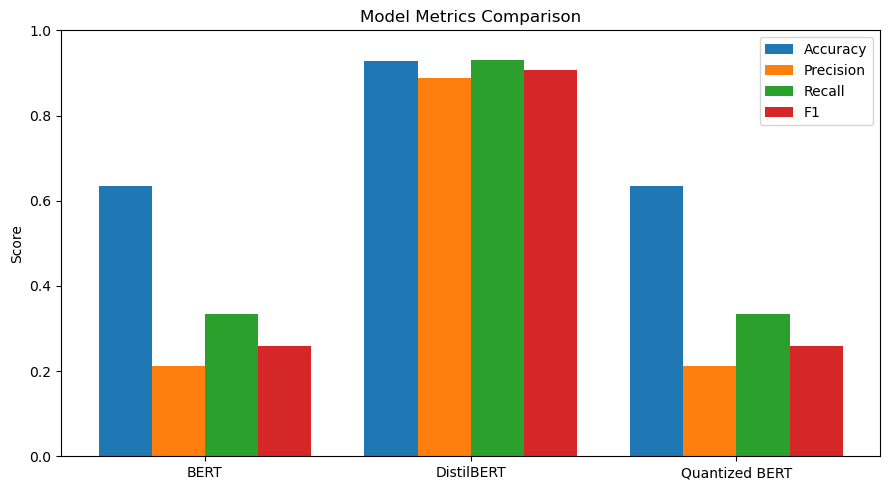

In [24]:
import pandas as pd

# --- Table of metrics ---
metrics_table = []
for name in results:
    metrics_table.append([
        name,
        f"{results[name]['accuracy']:.4f}",
        f"{results[name]['precision']:.4f}",
        f"{results[name]['recall']:.4f}",
        f"{results[name]['f1']:.4f}",
        f"{inf_times[name]*1000:.2f} ms",
        
    ])

df = pd.DataFrame(metrics_table, columns=["Model", "Accuracy", "Precision", "Recall", "F1-score", "Inference Time"])
print("\n=== Model Comparison Table ===")
print(df.to_markdown(index=False))

# --- Grouped bar chart for metrics ---
metric_names = ["accuracy", "precision", "recall", "f1"]
x = np.arange(len(results))
width = 0.2

fig, ax = plt.subplots(figsize=(9, 5))
for i, metric in enumerate(metric_names):
    vals = [results[name][metric] for name in results]
    ax.bar(x + i*width, vals, width, label=metric.capitalize())

ax.set_xticks(x + width*1.5)
ax.set_xticklabels(list(results.keys()))
ax.set_ylim(0, 1)
ax.set_ylabel("Score")
ax.set_title("Model Metrics Comparison")
ax.legend()
plt.tight_layout()
plt.show()

### **c. Analysis and Improvements**: 
Analyze deficiencies in the student model's learning. Suggest potential improvements or further research directions.


#### **Observed Deficiencies**

- **Poor Teacher and Quantized Model Performance:**  
  Both the original BERT and Quantized BERT models show low accuracy (63.4%) and F1-score (0.26), the Quantized model is just reducing the inference time apparently, but not improving any of the metrics.

- **Student Model Outperforms Teacher:**  
  DistilBERT (student) achieves much higher accuracy (92.8%) and F1-score (0.91) than the teacher. This might be due that the Bert fine-tuned model used was the one from 32 samples as we had understood that we should use our "best trained model" 


- **Potential Class Imbalance or Bias:**  
  The low precision and recall for BERT and Quantized BERT may indicate class imbalance, mode collapse, or overfitting to dominant classes.

---

#### **Suggested Improvements & Research Directions**


- **Improve Teacher Model Training:**  
  Creating a Bert model using all the dataset as it was used for the Distilled Model would probably improve its metrics to a higher level against the Distilled model.

- **Data Quality and Augmentation:**  
  Increase training data via augmentation (paraphrasing, back-translation, synonym replacement) to improve generalization. Address any class imbalance with class weighting or resampling.

- **Quantization-Aware Training:**  
  Use quantization-aware training (technique used to simulate the effects of low-precision during the training process) instead of post-training quantization to reduce performance loss in quantized models.


- **Error Analysis and Curriculum Learning:**  
  Analyze misclassified samples to identify systematic errors or biases. Use curriculum learning to help the student model generalize better, especially on harder examples.

---

**Summary:**  
The student model’s strong performance highlights issues with the teacher’s training and the distillation process. For robust, real-world deployment, focus on true knowledge distillation, better teacher training, data augmentation, and advanced distillation techniques.